# Prologue

In [260]:
from pymatgen.ext.matproj import MPRester
from pymatgen.core import Structure
from pymatgen.analysis.structure_matcher import StructureMatcher, ElementComparator
from trixs.spectra.core import XAS_Spectrum, XAS_Collation
from sklearn.ensemble import RandomForestClassifier
from trixs.spectra.util import NumpyEncoder
from tqdm import tqdm, tqdm_notebook
from pprint import pprint
import json
import os
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
rseed = 50
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold

storage_directory = '/Users/steventorrisi/Documents/TRIXS/data/MP_OQMD_combined'

target_elements_groups=[('Co','O')]#('Co','O')]#],('Fe','O'),('V','O'),('Cu','O'),
                        #('Ni','O'),('Cr','O'),('Mn','O'),('Ti','O')]



## Load in data for each pairs (using pre/post for now)

In [261]:
data_by_pair = {pair:[] for pair in target_elements_groups}
for pair in target_elements_groups:
    target_file = storage_directory + '/{}_{}_polynomials_pre-post_XY.json'.format(pair[0],pair[1])
    with open(target_file, 'r') as f:
        for line in f.readlines():
            cur_data = json.loads(line)
            if cur_data.get('one_hot_coord'):
                data_by_pair[pair].append(cur_data)
    sorted_keys = sorted(list(data_by_pair[pair][0]['labeled_coefficients'].keys()))



## Perform local processing of loaded-in raw data and get train / test split

In [262]:
target_coords = set([4,5,6])
for pair in target_elements_groups:
    X = []
    Y = []
    
    for point in data_by_pair[pair]:
        features = [point['labeled_coefficients'][key] for key in sorted_keys]
        label = point['coordination']
        if label not in target_coords:
            continue
        X.append(features)
        Y.append(label)

    X = np.array(X)
    Y = np.array(Y)
    
    skf = StratifiedKFold(n_splits=5)
    X_train, X_test, y_train, y_test = \
      train_test_split(X, Y, test_size=0.1,
                       random_state=rseed)
    X_train, X_valid, y_train, y_valid = \
      train_test_split(X_train, y_train, test_size=0.1,
                       random_state=rseed)

    

# Commence Training and Benchmarking

In [263]:
model = RandomForestClassifier(n_estimators = 500,random_state=42)
pprint(model.get_params())
model.fit(X_train,y_train)


{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Now; find F1 scores associated with each data set.

In [264]:
from trixs.machine_learning.benchmarks import precision_recall_matrix

model.score(X_valid,y_valid)
preds = model.predict(X_valid)
print(precision_recall_matrix(preds,y_valid,[4,5,6]))

[[0.86       0.87755102 0.86868687]
 [0.74285714 0.65       0.69333333]
 [0.8627451  0.91666667 0.88888889]]


## Get a model selector

In [265]:
sfm = SelectFromModel(model,max_features = 20)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=500, n_jobs=None,
                                                 oob_score=False,
                                                 random_state=42, verbose=0,
    

15 features are above the mean


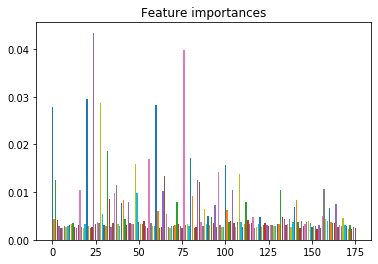

In [266]:
importances = list(model.feature_importances_)
#importances = list(sfm.feature_importances_)
#print(importances)

feature_importances = []
for i,key in enumerate(sorted_keys):
    feature_importances.append((key,importances[i]))
feature_importances = sorted(feature_importances, key = lambda x : x[1],reverse=True)
mean_imp = np.mean(importances)
max_imp = np.max(importances)
#pprint(feature_importances)
top_importances = [(x[0],x[1]/max_imp) for x in feature_importances if x[1]>mean_imp][:15]
print("{} features are above the mean".format(len(top_importances)))

plt.title("Feature importances")
for i in range(len(importances)):
    plt.bar(i,importances[i])
plt.show()

<Figure size 720x576 with 0 Axes>

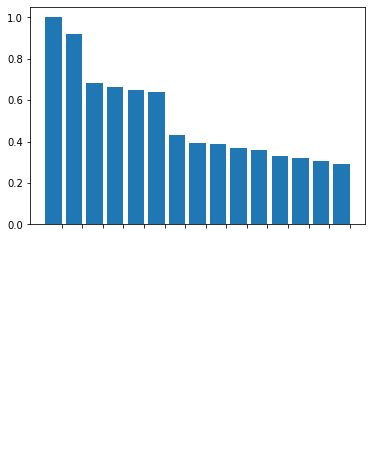

In [267]:
plt.figure(figsize=(10,8))

bar_x = np.arange(len(top_importances))
bar_y = [ti[1] for ti in top_importances]
labels = [ti[0] for ti in top_importances]
width = .8
fig, ax = plt.subplots()

rects1 = ax.bar(bar_x-width/2 , bar_y, width)
ax.set_xticks(bar_x)
ax.set_xticklabels(labels,rotation=75,color='white')
plt.show()


In [268]:
def label_to_hr_and_color(label,pre_post= True,
                         fraction=True):
    
    fingerprint = label.split(',')

    fingerprint = [x.split(':') for x in fingerprint]
    fingerprint = {x[0]:x[1] for x in fingerprint}
    for key in ['deg','fraction_size','chunk','coef']:
        fingerprint[key] = int(fingerprint[key])
    
    #print(fingerprint)
    coeff = fingerprint['coef']
    
    color_list = plt.cm.tab20(np.arange(0,20))
    color_idx = 0
    
    hrlabel=''
    
    tab10_colors = ['tab:blue', 'tab:orange', 
             'tab:green', 'tab:red',
             'tab:purple', 'tab:brown',
             'tab:pink', 'tab:gray',
             'tab:olive', 'tab:cyan']
    
    if fingerprint['fraction_size'] == 1:
        if fingerprint['loc']=='pre':
            hrlabel+='Entire Pre-Edge- '
            color='tab:blue'
        elif fingerprint['loc']=='post':
            hrlabel+='Entire Post-Edge- '
            color='tab:orange'
            
    
    elif fingerprint['fraction_size'] == 2:
        hrlabel+='Twofold- '
        if fingerprint['loc']=='pre':
            if fingerprint['chunk']==0:
                color='tab:blue'
            else:
                color='tab:orange'
        if fingerprint['loc'] == 'post':
            if fingerprint['chunk']==0:
                color='tab:green'
            else:
                color= 'tab:red'

        
    elif fingerprint['fraction_size'] == 4:
        hrlabel+='Fourfold- '
                    
        if fingerprint['loc'] == 'post':
            color_idx +=4
        color = tab10_colors[color_idx+fingerprint['chunk']]
        
    elif fingerprint['fraction_size'] == 5:
        hrlabel+='Fivefold- '   
        if fingerprint['loc'] =='post':
            color_idx += 5
        color = tab10_colors[color_idx+fingerprint['chunk']]
            
    elif fingerprint['fraction_size'] == 10:
        hrlabel+='Tenfold-'
        if fingerprint['loc'] =='post':
            color_idx +=10
            
        color = tab20(color_idx+fingerprint['chunk'])
        
    if coeff==0:
        hrlabel+= 'Const.'
    elif coeff==1:
        hrlabel+= 'Linear'
    elif coeff==2:
        hrlabel+= 'Quad.'
    elif coeff==3:
        hrlabel+= 'Cubic'   
    return hrlabel,color
    
print(labels[0])
print(label_to_hr_and_color(labels[0]))




loc:post,deg:3,fraction_size:10,chunk:5,coef:0
('Tenfold-Const.', (0.7803921568627451, 0.7803921568627451, 0.7803921568627451, 1.0))


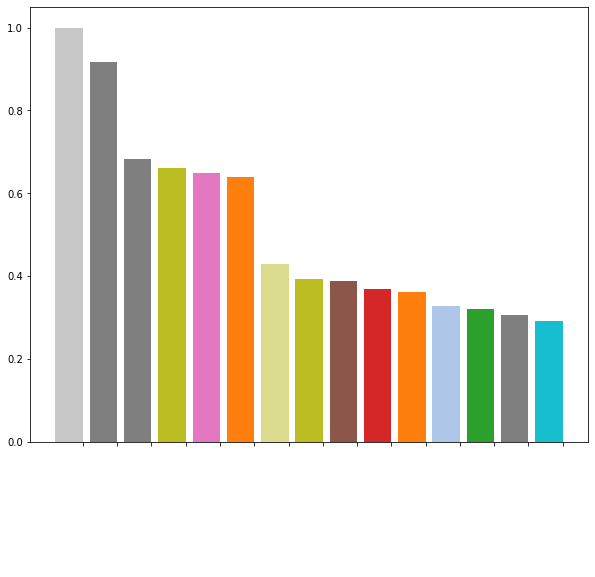

In [269]:
import matplotlib.cm as cm
fig, ax = plt.subplots(figsize=(10,8),)

tab20 = cm.get_cmap("tab20")
hr_labels = [label_to_hr_and_color(l)[0] for l in labels]
hr_colors = [label_to_hr_and_color(l)[1] for l in labels]

rects1 = ax.bar(bar_x-width/2 , bar_y, width, color=hr_colors)
ax.set_xticks(bar_x)
ax.set_xticklabels(hr_labels,rotation=90,color='white')
plt.show()


In [270]:
import matplotlib.colors as colors
import scipy.special as spec
from scipy.stats import norm

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

tab02 = plt.get_cmap('tab10')
left_cmap_2 = truncate_colormap(tab02,minval=0,maxval=.2,n=100)
right_cmap_2 = truncate_colormap(tab02,minval=.2,maxval=.4,n=100)

tab04 = plt.get_cmap('tab10')
left_cmap_4 = truncate_colormap(tab04,minval=0,maxval=.2,n=100)
right_cmap_4 = truncate_colormap(tab04,minval=.2,maxval=.4,n=100)

tab08 = plt.get_cmap('tab10')
left_cmap_8 = truncate_colormap(tab08,minval=0,maxval=.4,n=100)
right_cmap_8 = truncate_colormap(tab08,minval=.4,maxval=.8,n=100)

tab10 = plt.get_cmap('tab10')
left_cmap_10 = truncate_colormap(tab10,minval=0,maxval=.5,n=100)
right_cmap_10 = truncate_colormap(tab10,minval=.5,maxval=1.0,n=100)

tab20 = plt.get_cmap('tab20')
left_cmap_20 = truncate_colormap(tab20,minval=0,maxval=.5,n=100)
right_cmap_20 = truncate_colormap(tab20,minval=.5,maxval=1.0,n=100)

X = np.linspace(-5,5,500)
Y = spec.expit(X) + 2*norm.pdf(X,-.7,.8)+ .3*norm.pdf(X,-3.2,.4)
pi = np.argmax(Y)

cmap_lookup=  {2:  (left_cmap_2, right_cmap_2),
    4:  (left_cmap_4, right_cmap_4),
    8:  (left_cmap_8, right_cmap_8),
    10: (left_cmap_10, right_cmap_10),
    20: (left_cmap_20, right_cmap_20)}
splits = [4,8,10,20]
split_to_title ={2:"Entire Region",4:'Twofold',8:'Fourfold',10:'Fivefold',20:'Tenfold'}

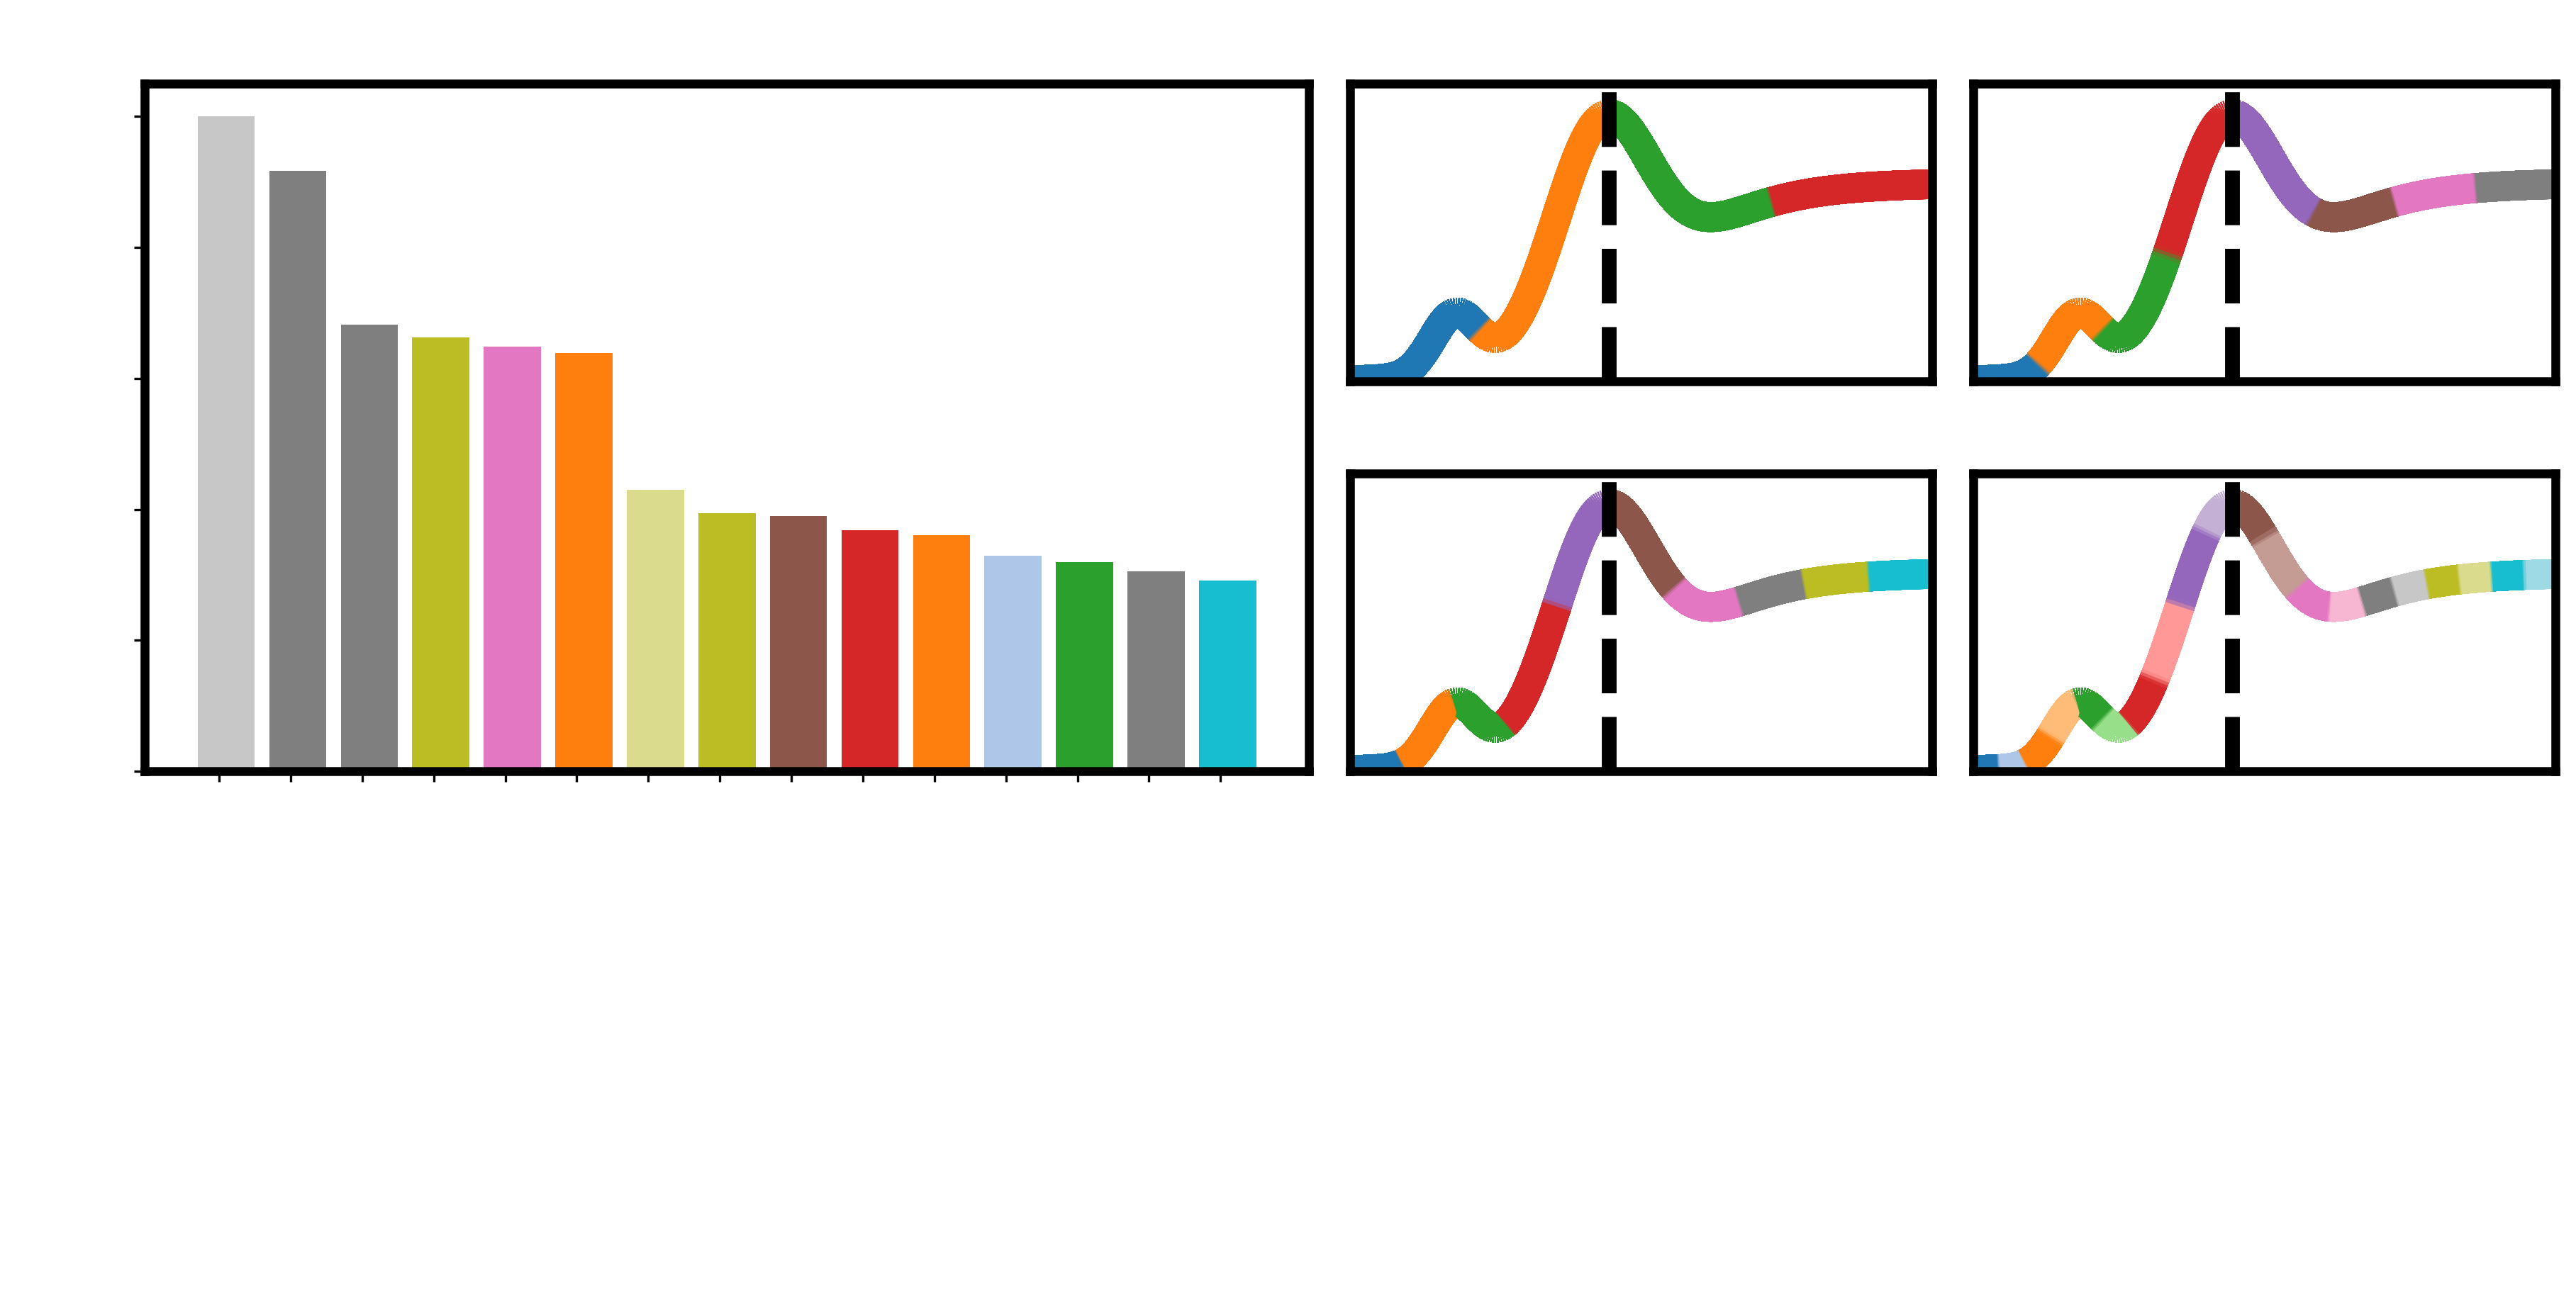

In [271]:
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.collections import LineCollection

fig2 = plt.figure(figsize=(12,6),constrained_layout = True,dpi=300)
gs = fig2.add_gridspec(2,4)

f2_ax1 = fig2.add_subplot(gs[:,:2])

f2_ax2 = fig2.add_subplot(gs[0,2])
f2_ax3 = fig2.add_subplot(gs[0,3])
f2_ax4 = fig2.add_subplot(gs[1,2])
f2_ax5 = fig2.add_subplot(gs[1,3])
all_axes = [f2_ax1,f2_ax2,f2_ax3,f2_ax4,f2_ax5]

for ax in all_axes:
    ax.spines['left'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    
ideal_axes = [f2_ax2,f2_ax3,f2_ax4,f2_ax5]


for ax, split_num in zip(ideal_axes,splits):
    
    X_l = X[:pi]
    X_r = X[pi:]
    Y_l = Y[:pi]
    Y_r = Y[pi:]
    normalize_left = mpl.colors.Normalize(vmin=min(X_l), vmax=max(X_l))
    normalize_right = mpl.colors.Normalize(vmin=min(X_r), vmax=max(X_r))

    l_segments = []
    for i in range(len(X_l))[:-1]:
        l_segments.append([(X_l[i],Y_l[i]) , (X_l[i+1],Y_l[i+1])])
        l_coll = LineCollection(l_segments, cmap=cmap_lookup[split_num][0],
                                norm=normalize_left,lw=10)
        l_coll.set_array(X_l)
        ax.add_collection(l_coll)

    r_segments = []
    for i in range(len(X_r))[:-1]:
        r_segments.append([(X_r[i],Y_r[i]) , (X_r[i+1],Y_r[i+1])])
        r_coll = LineCollection(r_segments, cmap=cmap_lookup[split_num][1],
                                norm=normalize_right,lw=10)
        r_coll.set_array(X_r)
        ax.add_collection(r_coll)

    ax.set_xlim(-5,5)
    ax.set_ylim(0,1.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axvline(X[pi],color='black',ls='--',lw=5)
    ax.set_title(split_to_title[split_num],color='White',size=15)
    

#gs = gridspec.GridSpec(4,5)
#ax = plt.subplot(gs[0,0])
#fig 
tab20 = cm.get_cmap("tab20")
hr_labels = [label_to_hr_and_color(l)[0] for l in labels]
hr_colors = [label_to_hr_and_color(l)[1] for l in labels]
ax = f2_ax1
rects1 = ax.bar(bar_x-width/2 , bar_y, width, color=hr_colors)
ax.set_xticks(bar_x-.5)
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],size=20,color='white')
#ax.ticklabel_format(axis='x',useOffset=True)
ax.set_title("Normalized RF Feature Rankings",color='white',size=20)
ax.set_xticklabels(hr_labels,rotation=60,color='white',ha='right',fontsize=15)
plt.show()


In [272]:
def label_to_color_codex(label):
    fingerprint = label.split(',')
    fingerprint = [x.split(':') for x in fingerprint]
    fingerprint = {x[0]:x[1] for x in fingerprint}
    for key in ['deg','fraction_size','chunk','coef']:
        fingerprint[key] = int(fingerprint[key])
    
    idx = fingerprint['chunk']
    if fingerprint['loc']=='post':
        idx+=fingerprint['fraction_size']        
    return (fingerprint['fraction_size'],idx)
print(labels[0])
print(label_to_color_codex(labels[0]))
    

loc:post,deg:3,fraction_size:10,chunk:5,coef:0
(10, 15)


In [273]:

fine_splits = [1,2,4,5,10]

#https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
color_ranking = ['red','lightcoral','salmon','orange','darkorange',
                'yellow','gold','olive','green','mediumseagreen','teal','blue','navy',
                'slateblue','darkviolet','purple','violet','orchid'] #[(230, 25, 75), (245, 130, 48), (255, 225, 25),
                # (60, 180, 75),
                # (0, 130, 200),  (145, 30, 180), 
                # (70, 240, 240), (240, 50, 230), (210, 245, 60), 
                # (250, 190, 190), (0, 128, 128), (230, 190, 255), 
                # (170, 110, 40), (255, 250, 200), (128, 0, 0), 
                # (170, 255, 195), (128, 128, 0), (255, 215, 180),
                # (0, 0, 128)]
#color_ranking = [np.array(c)/255 for c in color_ranking]
#pprint(color_codex)
split_to_title ={1:"Entire Region",2:'Twofold',4:'Fourfold',5:'Fivefold',10:'Tenfold'}

/Users/steventorrisi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


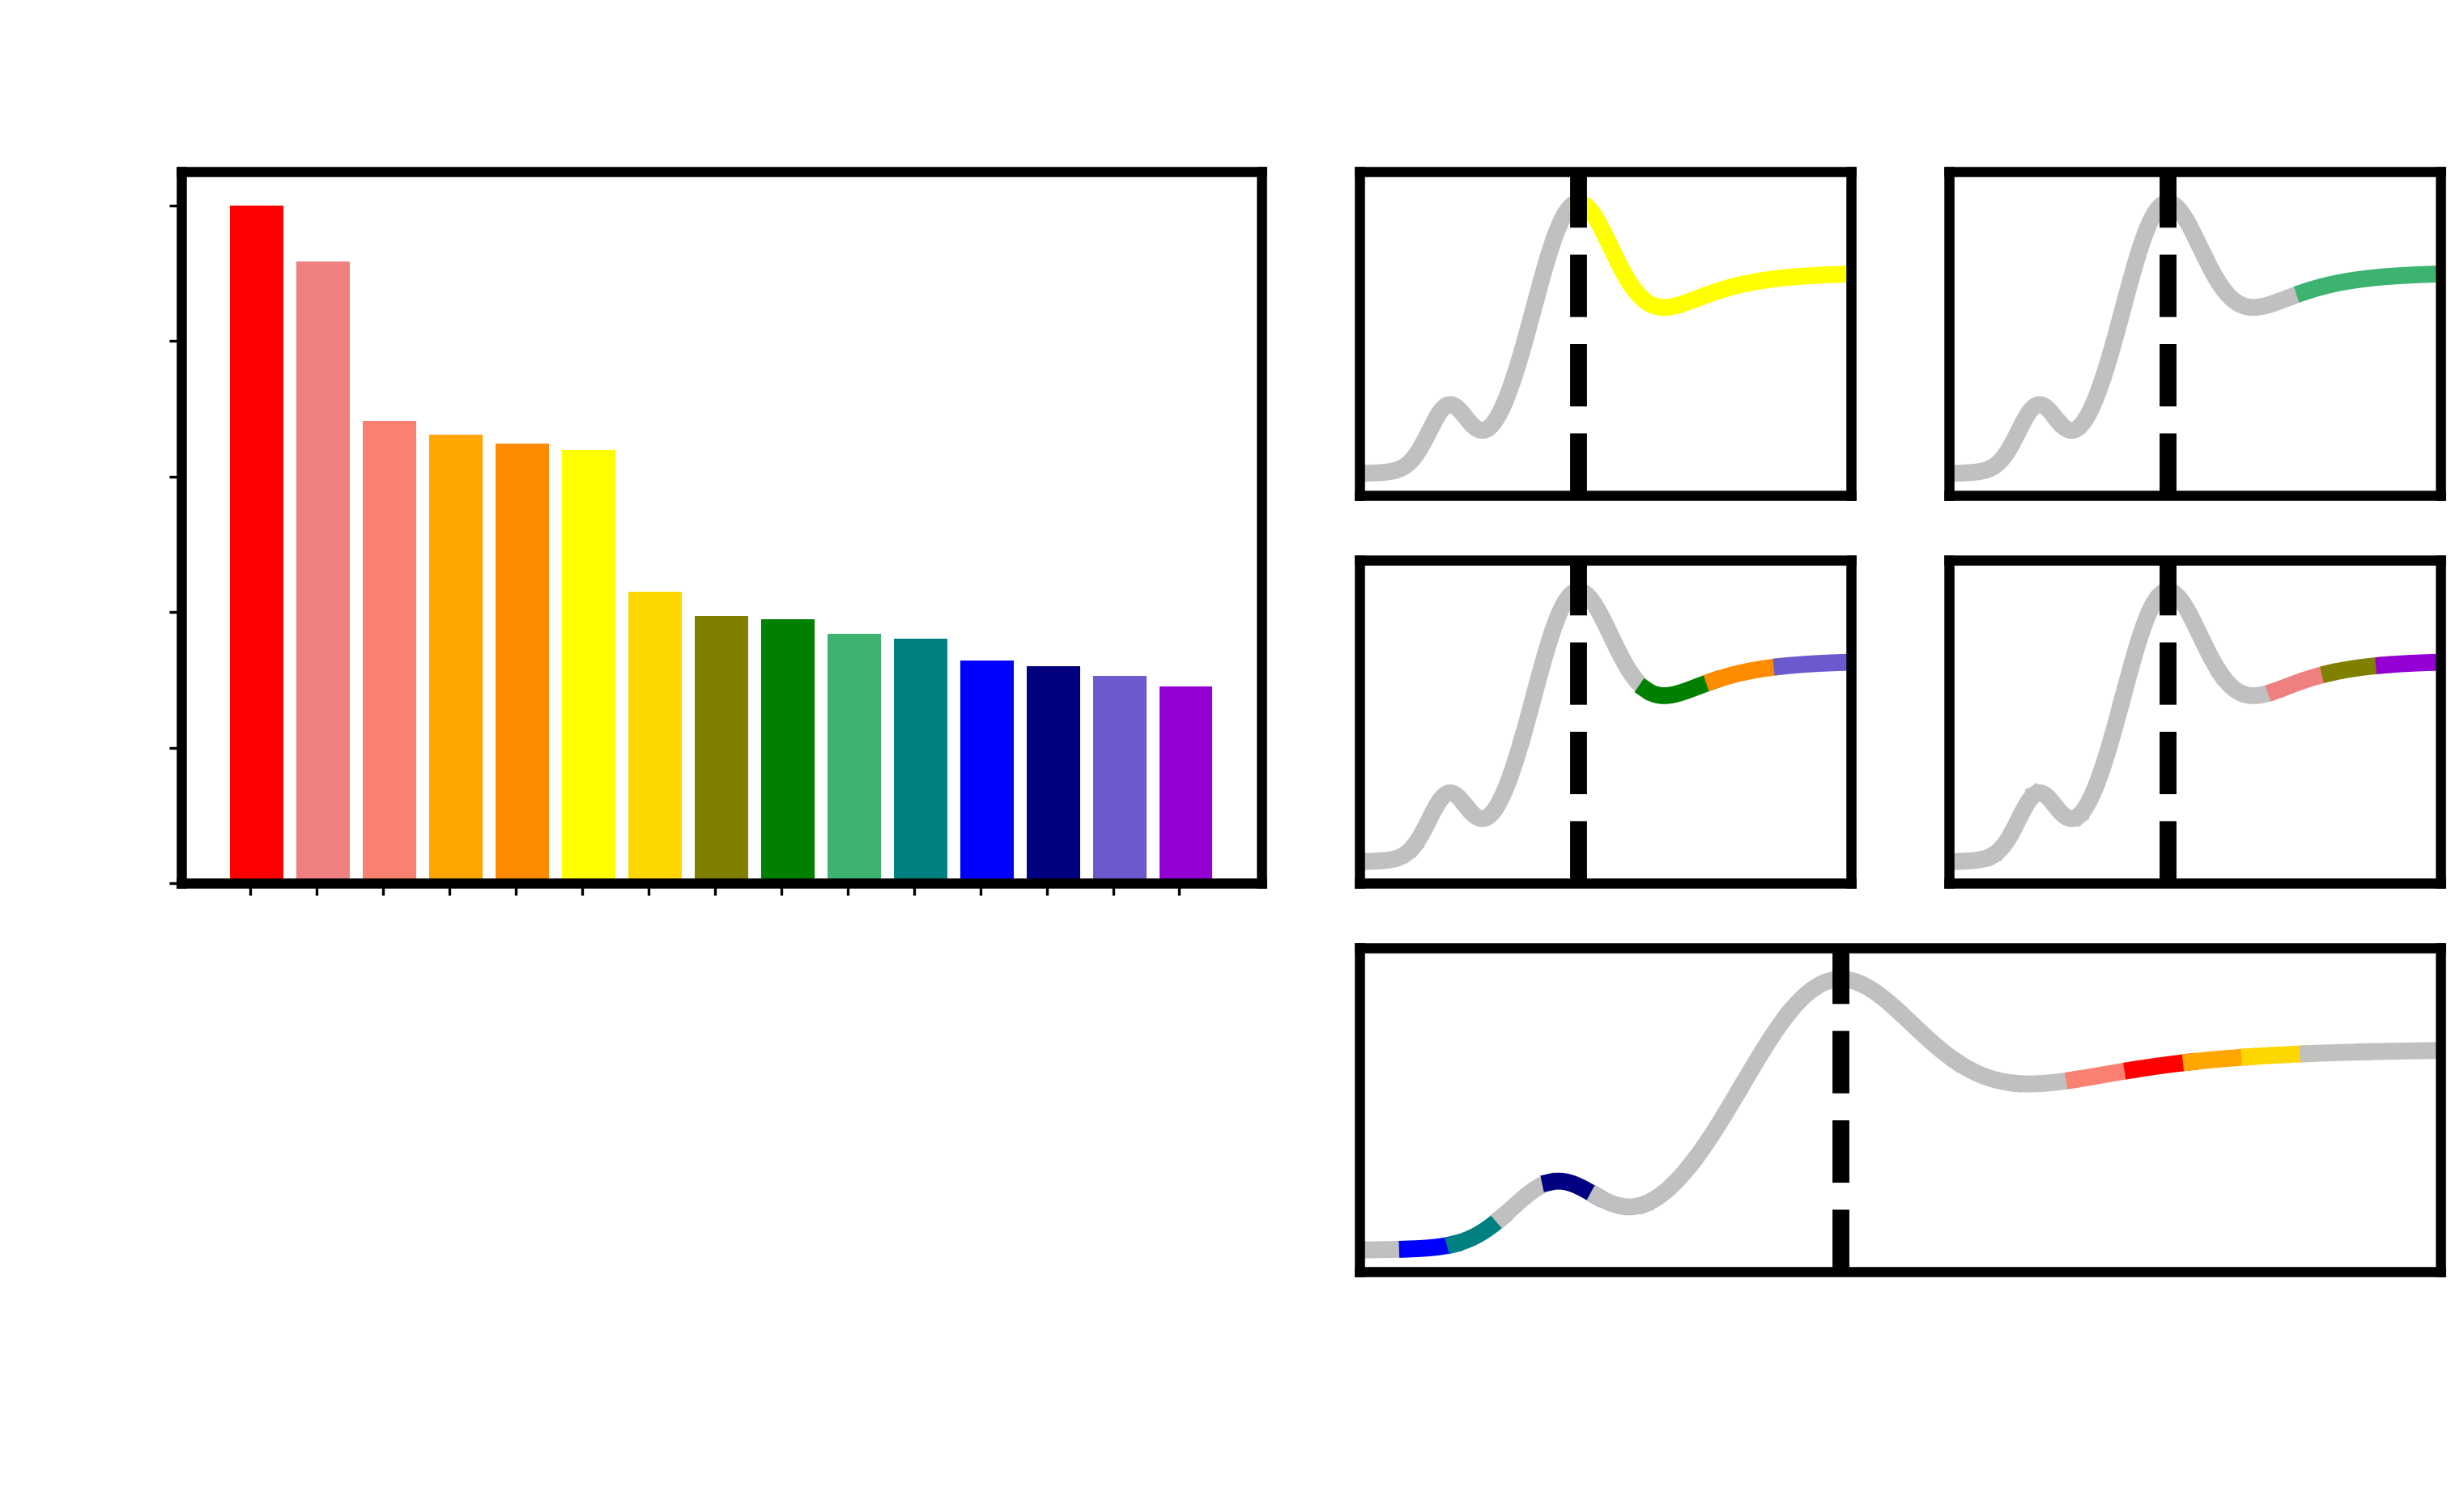

In [274]:
color_keys = [(1,0),(1,1)]
for i in range(4): color_keys.append((2,i))
for i in range(8): color_keys.append((4,i))
for i in range(10): color_keys.append((5,i))
for i in range(20): color_keys.append((10,i))
color_codex = {color_keys[i]: 'silver' if i%2 ==0 else 'silver' for i in range(len(color_keys))}

for i,l in enumerate(labels):
    #print(l,label_to_color_codex(l))
    cc_index = label_to_color_codex(l)
    if color_codex[cc_index]== 'gray' or color_codex[cc_index]== 'silver':
        color_codex[label_to_color_codex(l)] = color_ranking[i]

    
fig3 = plt.figure(figsize=(12,6),constrained_layout = True,dpi=300)
gs = fig3.add_gridspec(3,4)

f3_ax0 = fig3.add_subplot(gs[:2,:2])

f3_ax1 = fig3.add_subplot(gs[0,2])
f3_ax2 = fig3.add_subplot(gs[0,3])
f3_ax3 = fig3.add_subplot(gs[1,2])
f3_ax4 = fig3.add_subplot(gs[1,3])
f3_ax5 = fig3.add_subplot(gs[2,2:])
all_axes = [f3_ax0,f3_ax1,f3_ax2,f3_ax3,f3_ax4,f3_ax5]

for ax in all_axes:
    ax.spines['left'].set_linewidth(3)
    ax.spines['top'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['right'].set_linewidth(3)
    
ideal_axes = [f3_ax1,f3_ax2,f3_ax3,f3_ax4,f3_ax5]


for ax, split_num in zip(ideal_axes,fine_splits):
    
    lw = 5
    X_l = X[:pi]
    X_r = X[pi:]
    
    Y_l = Y[:pi]
    Y_r = Y[pi:]
    
    normalize_left  = mpl.colors.Normalize(vmin=min(X_l), vmax=max(X_l))
    normalize_right = mpl.colors.Normalize(vmin=min(X_r), vmax=max(X_r))

    if split_num==1:
        ax.plot(X_l,Y_l, color=color_codex[(1,0)],lw=lw)
        ax.plot(X_r,Y_r, color=color_codex[(1,1)],lw=lw)

    else:
        step = len(X_l)//split_num
        split_idx_l = [step*i for i in range(split_num)]
        split_idx_l.append(len(X_l))

        step = len(X_r)//split_num
        split_idx_r = [step*i for i in range(split_num)]
        split_idx_r.append(len(X_r))

        for i in range(split_num):
            sub_x = X_l[split_idx_l[i]:split_idx_l[i+1]]
            sub_y = Y_l[split_idx_l[i]:split_idx_l[i+1]]

            ax.plot(sub_x,sub_y, color=color_codex[(split_num,i)],lw=lw)

        for i in range(split_num):
            sub_x = X_r[split_idx_r[i]:split_idx_r[i+1]]
            sub_y = Y_r[split_idx_r[i]:split_idx_r [i+1]]

            ax.plot(sub_x,sub_y, color=color_codex[(split_num,i+split_num)],lw=lw)


    ax.set_xlim(-5,5)
    ax.set_ylim(-.1,1.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axvline(X[pi],color='black',ls='--',lw=5)
    ax.set_title(split_to_title[split_num],color='White',size=15)
    

tab20 = cm.get_cmap("tab20")
hr_labels = [label_to_hr_and_color(l)[0] for l in labels]
hr_colors = [label_to_hr_and_color(l)[1] for l in labels]

ax = f3_ax0
rects1 = ax.bar(bar_x-width/2 , bar_y, width, color=color_ranking)
ax.set_xticks(bar_x-.5)
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],size=20,color='white')
#ax.ticklabel_format(axis='x',useOffset=True)
ax.set_title("Top 15 Normalized \n {}O RF Feature Rankings".format(pair[0]),color='white',size=20)
ax.set_xticklabels(hr_labels,rotation=60,color='white',ha='right',fontsize=15)
plt.subplots_adjust()
plt.show()
